# Интерполяция и аппроксимация 

In [1]:
from matplotlib import pyplot as plt


def configure_matplotlib():
    plt.rc('text', usetex=True)
    plt.rcParams["axes.titlesize"] = 28
    plt.rcParams["axes.labelsize"] = 24
    plt.rcParams["legend.fontsize"] = 24
    plt.rcParams["xtick.labelsize"] = plt.rcParams["ytick.labelsize"] = 18
    plt.rcParams["text.latex.preamble"] = r"""
    \usepackage[utf8]{inputenc}
    \usepackage[english,russian]{babel}
    \usepackage{amsmath}
    """

configure_matplotlib()



## Интерполяция

Подмодуль [scipy.interpolate](https://docs.scipy.org/doc/scipy/reference/interpolate.html#module-scipy.interpolate) содержит в себе методы для интерполяции.

Коротко про интерполяцию можно почитать в [википедии](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D1%82%D0%B5%D1%80%D0%BF%D0%BE%D0%BB%D1%8F%D1%86%D0%B8%D1%8F). Более подробное изложение можно найти в {cite}`Samarsky`.

> Задача интерполирования состоит в том, чтобы по значениям функции $f(x)$ в нескольких точках отрезка восстановить ее значения в остальных точках этого отрезка. Разумеется, такая задача допускает сколь угодно много решений. Задача интерполирования возникает, например, в том случае, когда известны результаты измерения $y_h= f(x, k)$ некоторой физической величины $f(x)$ в точках $x_k, k = 0, 1, ..., n$, и требуется определить ее значения в других точках. Интерполирование используется также при сгущении таблиц, когда вычисление значений $f(x)$ трудоемко. Иногда возникает необходимость приближенной замены или аппроксимации данной функции другими функциями, которые легче вычислить. В частности, рассматривается задача о наилучшем приближении в нормированном пространстве $H$, когда заданную функцию $f\in H$ требуется заменить линейной комбинацией $\phi$ заданных элементов из $H$ так, чтобы отклонение $||f—\phi||$ было минимальным. Результаты и методы теории интерполирования и приближения функций нашли широкое применение в численном анализе, например при выводе формул численного дифференцирования и интегрирования, при построении сеточных аналогов задач математической физики {cite}`Samarsky`.

Для того чтобы рассмотреть интерполяцию, сгенерируем данные. Т.е. сгенерируем массив узлов интерполяционной сетки `x_data` и значений `y_data` некоторой функции $f$ в узлах этой сетки при разном количестве известных точек.

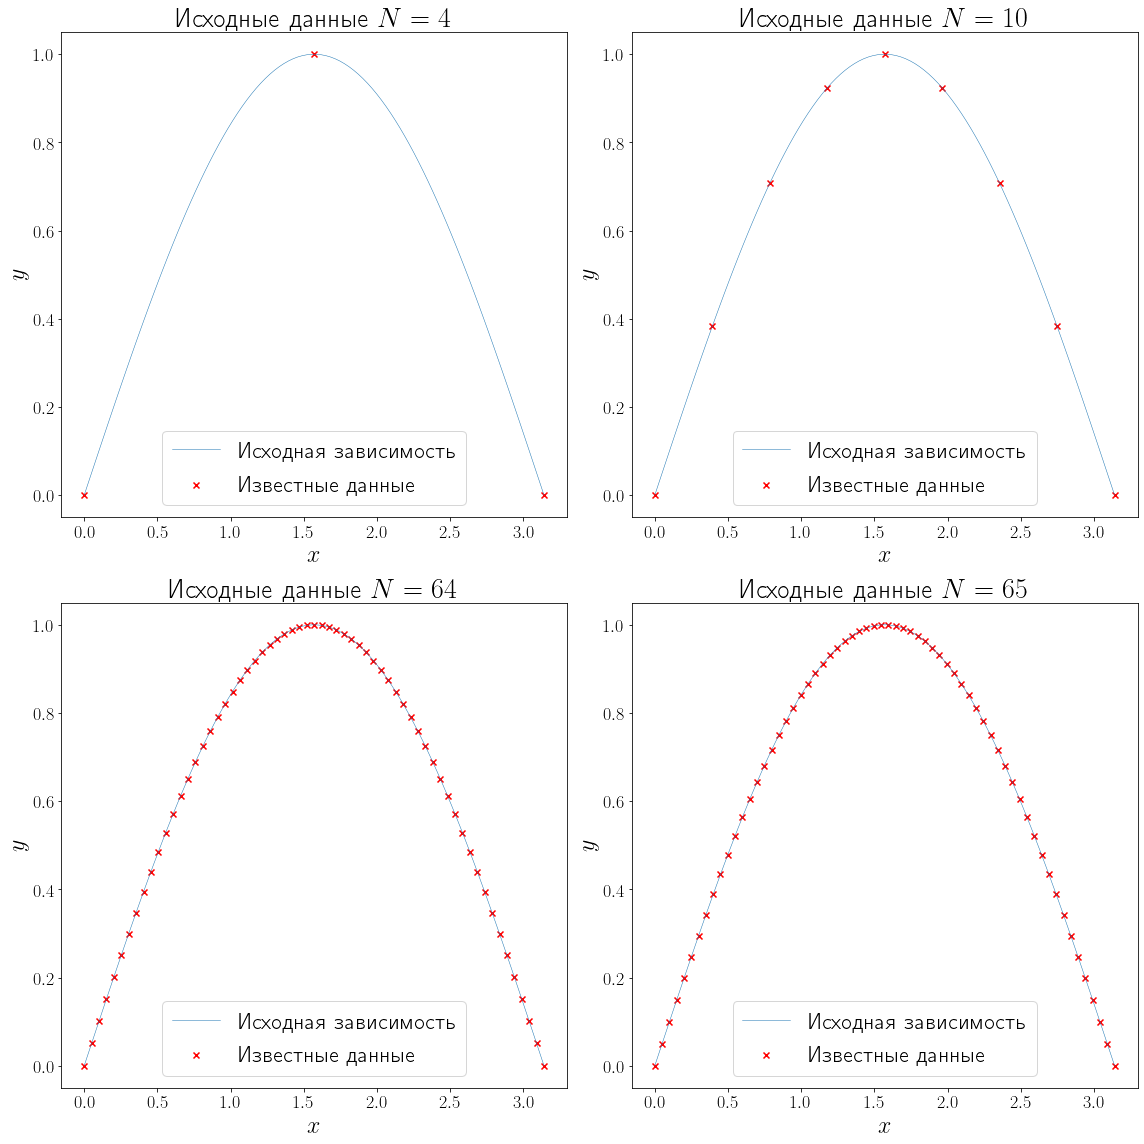

In [2]:
import numpy as np

L = 0
R = np.pi
n_points = (4, 10, 64, 65)
f = np.sin

xh = np.linspace(L, R, 100) 
yh = f(xh)
    

def generate_data(f, L, R, n):
    x_data = np.linspace(L, R, n-1)
    y_data = f(x_data)
    return x_data, y_data    


def plot_problem(ax, x_data, y_data):
    ax.plot(xh, yh, linewidth=0.5, label="Исходная зависимость")
    ax.scatter(x_data, y_data, marker="x", color="red", label="Известные данные")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 16), layout="tight")
for ax, N in zip(axs.flatten(), n_points):
    x_data, y_data = generate_data(f, L, R, N)
    plot_problem(ax, x_data, y_data)
    ax.set_title(f"Исходные данные ${N=}$")
    ax.legend()



Теперь когда данные готовы, осталось произвести интерполяцию. Методов интерполяции существует очень много. Рассмотрим полиномиальную интерполяцию и сплайн интерполяцию.

### Полиномиальная интерполяция

Полиномиальная интерполяция основывается на том факте, что существует единственный полином $P_{N}(x) = a_0 + a_1 x + \cdots + a_{N} x ^ N $ степени $N$, проходящий через точки $\{(x_1, y_1), ..., (x_{N + 1}, y_{N + 1})\}$, если $x_i \neq x_j \quad \forall i, j = 1, \cdots, N + 1, \quad i \neq j$.  

Недостатком полиномиальной интерполяции является её нестабильность. Полиномиальная интерполяция проявляет себя очень плохо при больших $N$. 

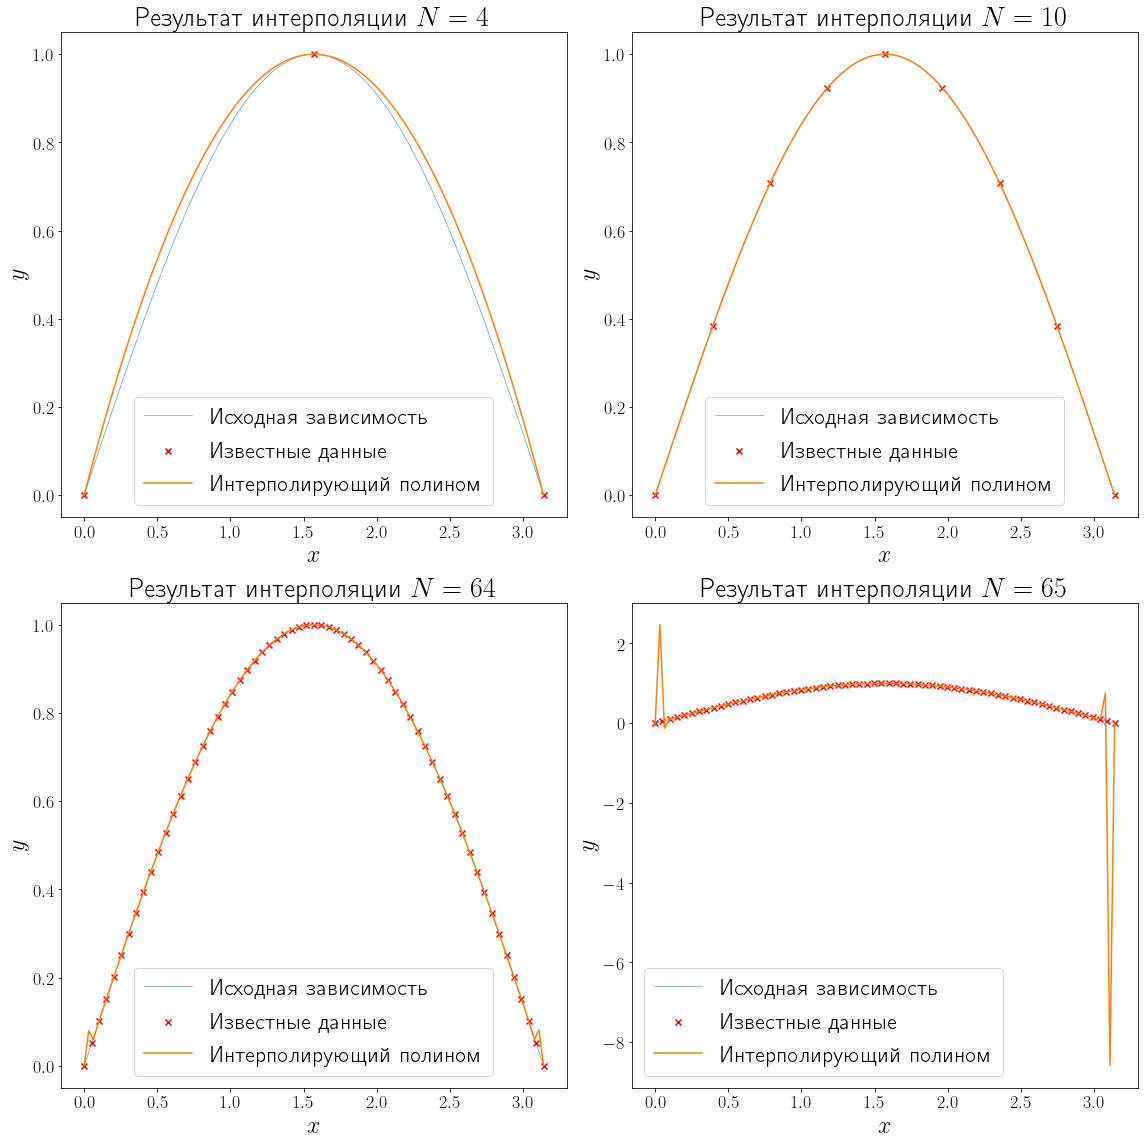

In [10]:
from scipy import interpolate

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 16), layout="tight")
for ax, N in zip(axs.flatten(), n_points):
    x_data, y_data = generate_data(f, L, R, N)
    plot_problem(ax, x_data, y_data)

    poly = interpolate.KroghInterpolator(x_data, y_data)
    y_poly = poly(xh)
    ax.plot(xh, y_poly, label="Интерполирующий полином")
    
    ax.set_title(f"Результат интерполяции ${N=}$")
    ax.legend()


### Сплайн интерполяция

> Интерполирование многочленом ... на всем отрезке $[a, b]$ с использованием большого числа узлов интерполяции часто приводит к плохому приближению, что объясняется сильным накоплением погрешностей в процессе вычислений. Кроме того, из-за расходимости процесса интерполяции увеличение числа узлов не обязано приводить к повышению точности. Для того чтобы избежать больших погрешностей, весь отрезок $[a, b]$ разбивают на частичные отрезки и на каждом из частичных отрезков приближенно заменяют функцию $f(х)$ многочленом невысокой степени (так называемая кусочно-полиномиальная интерполяция). Одним из способов интерполирования на всем отрезке является интерполирование с помощью сплайн-функций. Сплайн-функцией или сплайном называют кусочно-полиномиальную функцию, определенную на отрезке $[a, b]$ и имеющую на этом отрезке некоторое число непрерывных производных {cite}`Samarsky`.  

Например, если взять в качестве сплайн-функции полином первой степени, то на выходе получится кусочно-линейная интерполяция. 

Text(0.5, 1.0, 'Кусочно-линейная интерполяция')

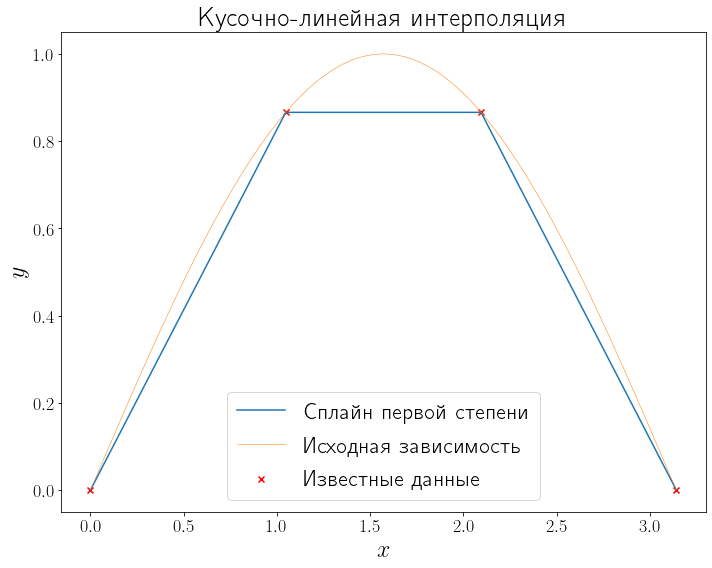

In [11]:
x_data, y_data = generate_data(f, L, R, 5)
linear = interpolate.interp1d(x_data, y_data, kind="linear")
y_linear = linear(xh)

fig, ax = plt.subplots(figsize=(10, 8), layout="tight")
ax.plot(xh, y_linear, label="Сплайн первой степени")
plot_problem(ax, x_data, y_data)
ax.legend()
ax.set_title("Кусочно-линейная интерполяция")

Очень часто выбирают полином третьей степени, которые позволяют строить гладкие интерполирующие полиному и разумно ведут себя между точками во многих случаях.

Text(0.5, 1.0, 'Интерполяция кубическим сплайном')

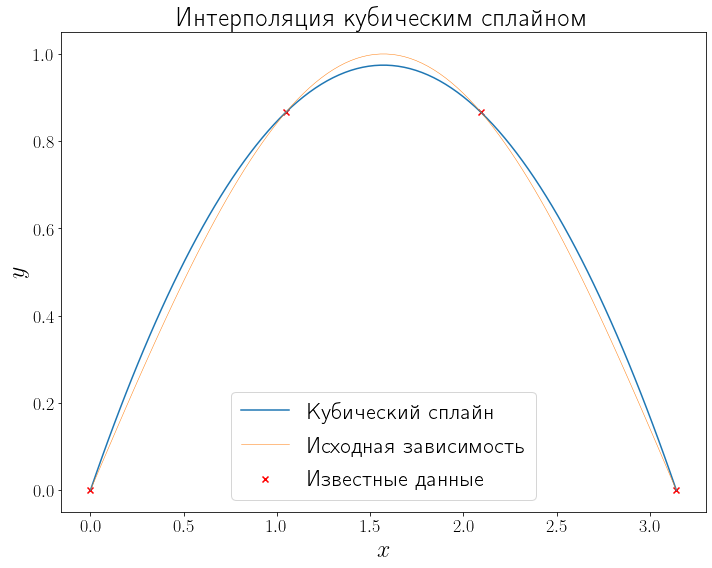

In [12]:
cubic = interpolate.interp1d(x_data, y_data, kind="cubic")
y_cubic = cubic(xh)

fig, ax = plt.subplots(figsize=(10, 8), layout="tight")
ax.plot(xh, y_cubic, label="Кубический сплайн")
plot_problem(ax, x_data, y_data)
ax.legend()
ax.set_title("Интерполяция кубическим сплайном")

## Аппроксимация функций

При интерполировании ставится цель восстановить исходную зависимость $y = f(x)$ таким образом по набору точек, через которые функция $f$ проходит в точности. Но что если значение исходной функции $f$ в точках $x_i, \, i=0,\ldots,N$ известно не точно, а в пределах какой-то погрешности или с точностью до какой-то случайной величины, т.е., например, $y_i = f(x_i) + \varepsilon_i, \, i = 0, \ldots, N$. В таком случае такое строгое требование на то, чтобы решение $\phi(x)$ в точности проходило через все точки $(x_i, y_i), \, i=0, ..., N$ не имеет большого смысла и может быть ослаблено, например, до поиска такой функции $\phi$ из определенного класса функций, которая меньше всего отклоняется от значений $(x_i, y_i),\, i=0,..., n$.  

Очень распространенным подходом в таком случае является метод наименьших квадратов, при котором отклонение формализуется в виде суммы квадратов отклонений аппроксимирующей функции $\phi$ в точках $x_i, \, i=0,\ldots,N$ от измерений $y_i, \, i=0,\ldots,N$. Пусть решение ищется в классе функций $\{\phi_p\colon \mathbb{R}\to\mathbb{R}\mid p\in P\}$, тогда задача аппроксимации сводится к задаче минимизации

$$
    \sum_{i=0}^{N}||\phi_p(x_i) - y_i||^2 \sim \min_{p\in P}.
$$


```{note}
Многие методы аппроксимации легко обобщаются на многомерные случаи.
```

При такой постановке часто выделяют линейную и нелинейную аппроксимации. Аппроксимация является **линейной**, если $\phi_p(x)$ линейно зависит от параметров $p$. 


```{note}
Аппроксимация функций реализована во множестве других библиотек, таких как [statsmodels](https://www.statsmodels.org/stable/index.html), [scikit-learn](https://scikit-learn.org/stable/) и некоторых других. 
```

### Линейная аппроксимация

Очень распространенным случаем линейной аппроксимации является полиномиальная аппроксимация, при которой решение ищется в виде полинома $P_{N}(x) = a_0 + a_1 x + \cdots + a_{n} x^n$, т.е. решается задача 

$$
    \sum_{i=0}^{N}||a_0 + a_1 x_i + \cdots + a_{n} x_i^n - y_i||^2 \sim \min_{a_0, a_1, \ldots, a_n \in \mathbb{R}^{n+1}}.
$$

Если все $x_i, \, i=1,\ldots,N$ все различны, то при $n=N$ существует глобальный минимум, который соответствует проходящему через все точки интерполирующему полиному, поэтому обычно решение ищется при $n<N$. 

Сгенерируем данные для тестирования полиномиальной интерполяции при различных $n$. В качестве исходной зависимости выберем функцию 

$$
f(x)=2e^{-3x} + 4,
$$

сгенерируем $N = 11$ точек $x_i, \, i=0, \ldots, 10$ равномерно распределенных на отрезке $[0, 1]$ и искусственно добавим распределенный по Гауссу шум к значениям функции $f$ в этих точках: $\{y_i=f(x_i) + \varepsilon_i, \, \varepsilon_i \sim \mathcal{N}(0, \sigma^2), \, i=0, \ldots, 10\}$.

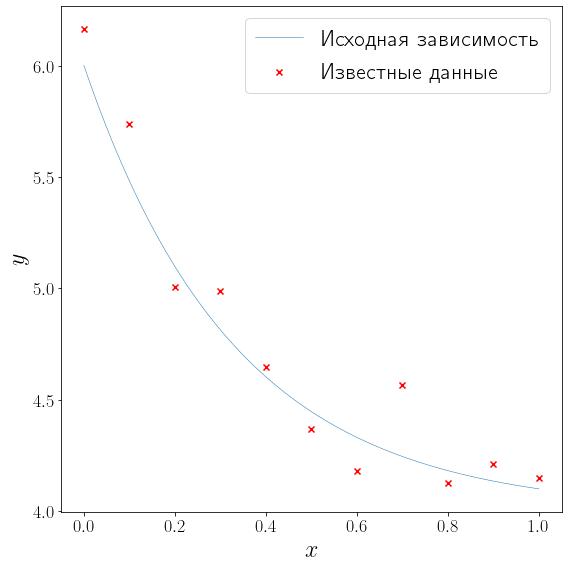

In [35]:
L = 0
R = 1

def f(x):
    return 2*np.exp(-3*x) + 4


N = 11
sigma = 0.2
x_data = np.linspace(L, R, N)
y_data = f(x_data) + np.random.normal(loc=0, scale=sigma, size=N)

xh = np.linspace(0, 1, 100) 
yh = f(xh)                   


fig, ax = plt.subplots(figsize=(8, 8), layout="tight")
plot_problem(ax, x_data, y_data)
ax.legend()

Решить задачу полиномиальной аппроксимации можно средствами модуля [numpy.polynomial](https://numpy.org/doc/stable/reference/routines.polynomials.package.html#module-numpy.polynomial). В частности подогнать полином заданной степени методом наименьших квадратов можно с помощью метода [numpy.polynomial.Polynomial.fit](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.Polynomial.fit.html).

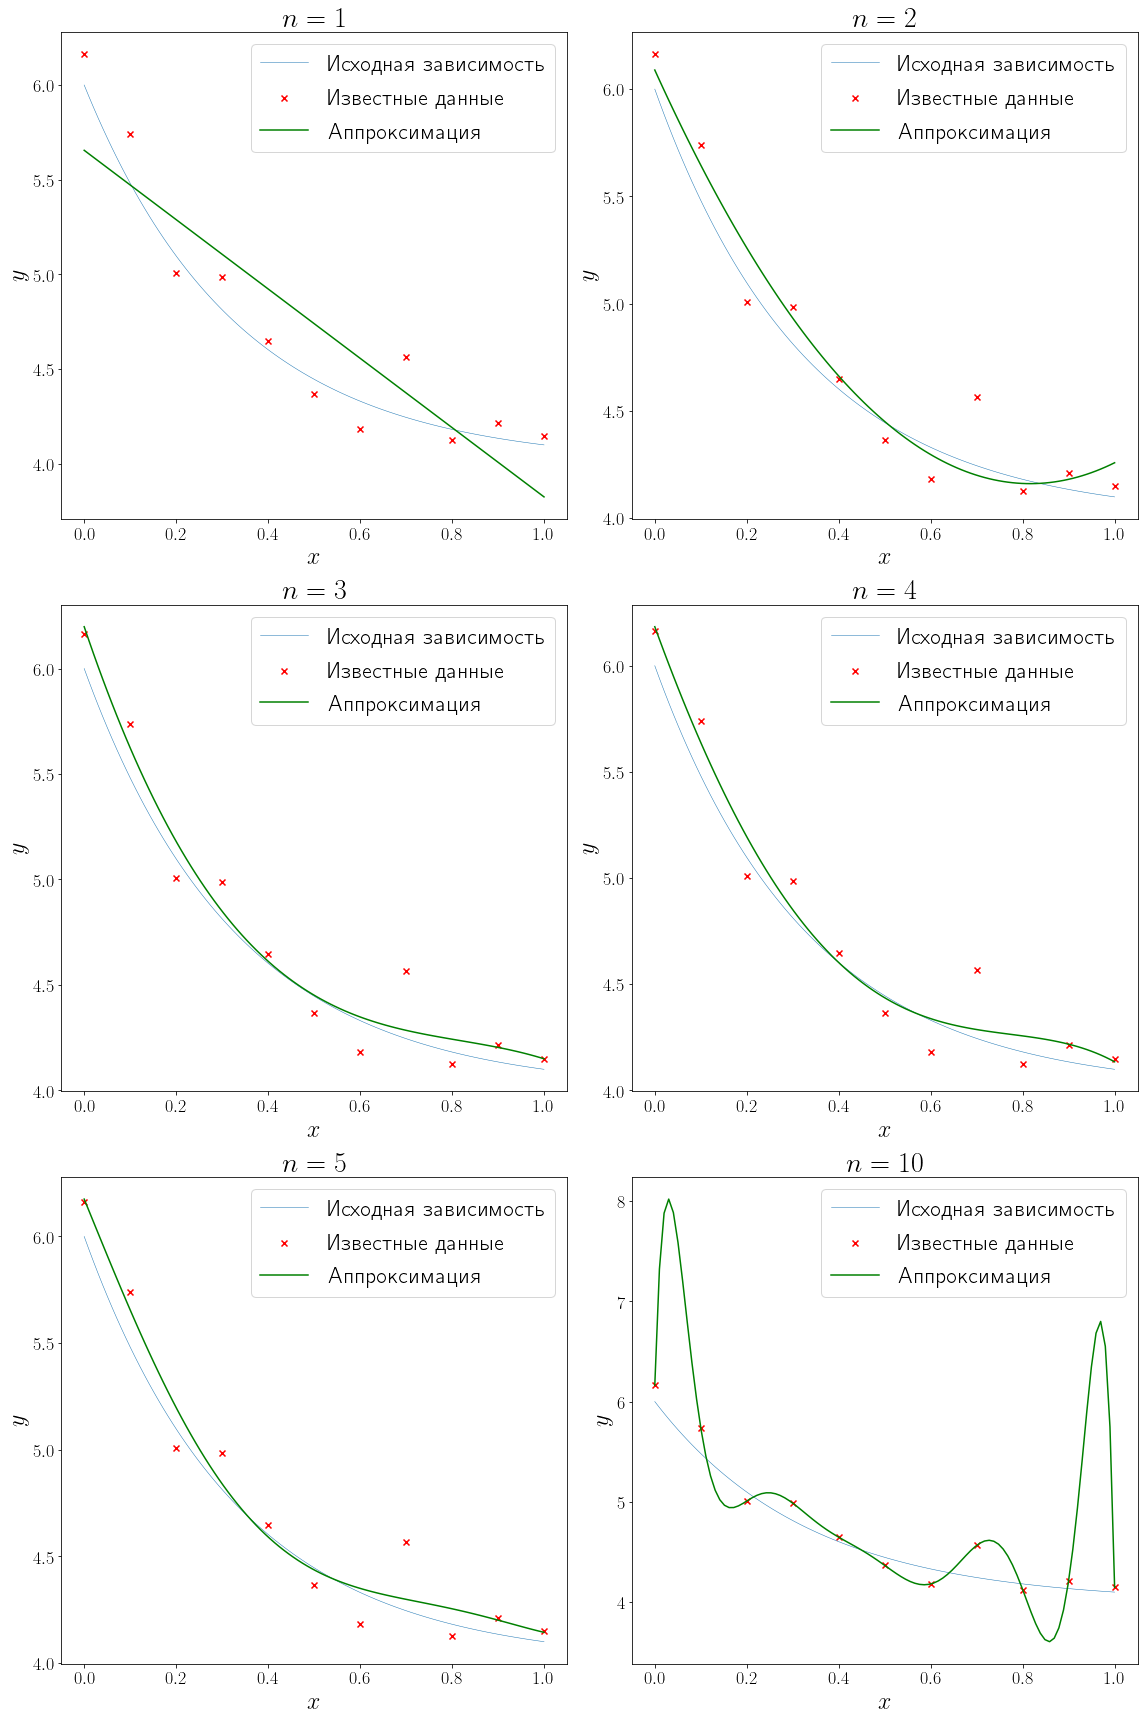

In [36]:
from numpy.polynomial import Polynomial

degrees = (1, 2, 3, 4, 5, 10)


fig, axs = plt.subplots(figsize=(16, 24), nrows=3, ncols=2, layout="tight")
for ax, degree in zip(axs.flatten(), degrees):
    approximation = Polynomial.fit(x_data, y_data, degree)
    plot_problem(ax, x_data, y_data)
    ax.plot(xh, approximation(xh), color="green", label="Аппроксимация")
    ax.set_title(f"$n = {degree}$")
    ax.legend()

В более общем случае при линейной аппроксимации решение ищется в виде линейной комбинации любых функций $\varphi(x) = c_1\varphi_1(x) + \cdots + c_n\varphi_n(x)$ и задача аппроксимации сводится к подбору коэффициентов $c_i, \, i=1,\ldots,n$ посредством минимизации

$$
    \sum_{i=0}^{N}||c_1 \varphi_1(x_1) + \cdots + c_n \varphi_n(x_i) - y_i||^2 \sim \min_{c_1, \ldots, c_n \in \mathbb{R}^n}.
$$

Полиномиальная интерполяция получается при $\varphi_i(x) = x^i$. Можно показать, что решение оптимизационной задачи выше эквивалентно минимизации невязки системы линейных алгебраических уравнений 

$$
\begin{pmatrix}
\varphi_1(x_0) &\cdots & \varphi_k(n_0) \\
\vdots & \ddots & \vdots \\
\varphi_1(x_N) &\cdots & \varphi_k(n_N)
\end{pmatrix}
\begin{pmatrix}
c_1 \\ \vdots \\ c_n
\end{pmatrix}=
\begin{pmatrix}
y_0 \\ \vdots \\ y_N
\end{pmatrix}.
$$

За решение таких задач отвечает метод [linalg.lstsq](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html). В качестве примера аппроксимируем тот же набор точек, но решение будем искать в виде 

$$
\varphi_{\alpha, \beta}(x) = \alpha + \beta e^{-x} + \gamma x^2.
$$

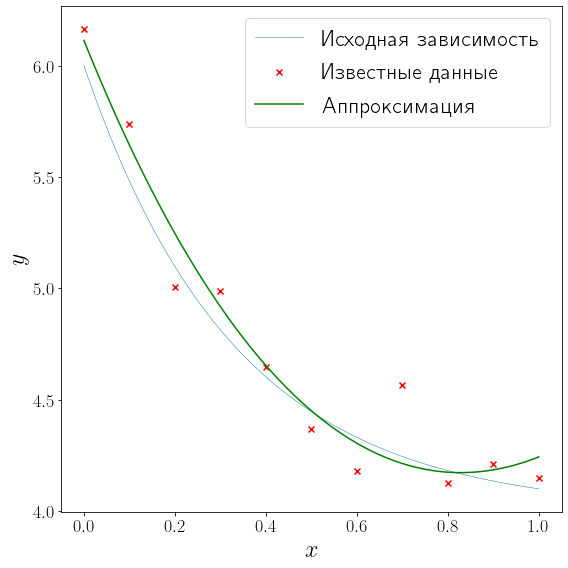

In [37]:
from scipy import linalg

def approximation(x, alpha, beta, gamma):
    return alpha + beta*np.exp(-x) + gamma*np.square(x)


A = np.vstack([
    np.ones_like(x_data), np.exp(-x_data), np.square(x_data)
]).T

b = y_data

(alpha, beta, gamma), *_ = linalg.lstsq(A, b)

fig, ax = plt.subplots(figsize=(8, 8), layout="tight")
plot_problem(ax, x_data, y_data)
ax.plot(xh, approximation(xh, alpha, beta, gamma), color="green", label="Аппроксимация")
ax.legend()

### Нелинейная аппроксимация



Будем аппроксимировать данные функцией вида

$$
\phi_{\alpha, \beta, \gamma}(x) = \alpha e^{\beta x} + \gamma.
$$

Исходная функция $f(x)=2e^{-3x} + 4$ совпадает с $\phi_{\alpha, \beta, \gamma}(x)$ при $\alpha=2$, $\beta=-3$ и $\gamma=4$, т.е. теоретически можно восстановить точное решение. 
Аппроксимация не является линейной, т.к. $\phi_{\alpha, \beta, \gamma}$ зависит от параметра $\beta$ экспоненциально. Метод [optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) позволяет искать приближенное решение задачи нелинейной аппроксимации.

Чтобы воспользоваться методом `optimize.curve_fit`, необходимо определить функцию, которая первым своим аргументом принимает $x$ (может быть скаляром, а может быть и вектором), а остальными аргументами принимает параметры $p$. В примере ниже это функция `approximation`.

Далее этому методу `optimize.curve_fit` передаётся эта самая функция, данные, под которые эту функцию необходимо подогнать, и начальное приближение $p_0$ используемое в качестве стартовой точки для подбора параметров, при которых достигается минимальное среднее квадратичное отклонение $\phi_p$ от заданного набора точек.


Найденные параметры: 
alpha = 2.130,
beta = -3.378,
gamma = 4.081,



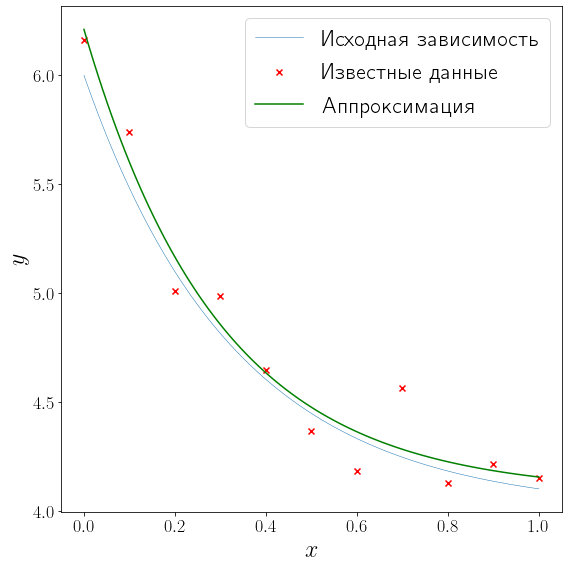

In [39]:
from scipy import optimize

def approximation(x, alpha, beta, gamma):
    return alpha * np.exp(beta * x) + gamma

(alpha, beta, gamma), _ = optimize.curve_fit(approximation, x_data, y_data, p0=[3, -6, 10])


fig, ax = plt.subplots(figsize=(8, 8), layout="tight")
plot_problem(ax, x_data, y_data)
ax.plot(xh, approximation(xh, alpha, beta, gamma), color="green", label="Аппроксимация")
ax.legend()

print(f"""
Найденные параметры: 
{alpha = :.3f},
{beta = :.3f},
{gamma = :.3f},
""")

Видим, что найденные значения коэффициентов $\alpha, \beta$ и $\gamma$ с неплохой точностью совпали с истинными и аппроксимирующая кривая довольно близко проходит к исходной $f(x)$.


```{note}
В случае нелинейной аппроксимации следует проявлять особую осторожность, т.к. функционал среднеквадратичного отклонения минимизируется численными методами и начальное приближение $p_0$ играет большую роль: при не удачном $p_0$ алгоритм может сойтись не туда или не сойтись вообще. 
```

## Список литературы

```{bibliography}
:style: unsrt
```